In [1]:
# use dev/pleget/add_plot_anisotropic branch to run treegp.
import treegp
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
kwargs_scatter = {'vmin':-10, 'vmax':10, 'cmap':plt.cm.seismic, 's':10}

def scatter_plot_setup(cb_title = ''):
    _ = plt.axis('equal')
    cb = plt.colorbar()
    cb.set_label(cb_title, fontsize=14)
    plt.xlabel('u (arcsec)', fontsize=14)
    plt.ylabel('v (arcsec)', fontsize=14)

In [3]:
# decorator to evaluate run time of some function.
def timer(f):
    import functools

    @functools.wraps(f)
    def f2(*args, **kwargs):
        import time
        import inspect

        t0 = time.time()
        result = f(*args, **kwargs)
        t1 = time.time()
        fname = repr(f).split()[1]
        print("time for %s = %.4f" % (fname, t1 - t0))
        return result

    return f2

# wrapper class arround treegp
class gp_treegp():
    """
    Here are the meaning of the parameters to make the fit. Here I Hard coded them, but in reality
    I fined tune them to make it work on the whole dataset I had at the time. It needs to be fine tune for
    the survey you are looking at (I mean the set of parameters I choose for HSC will work likely for the 
    whole HSC data but I am not sure if it will work as it is for LSST). 
    
    :kernel:    str. The type of function that will be used to modeled spatial correlation. On HSC it was clear that
                     AnisotropicVonKarman was a better choice compared to RBF/Gaussian correlation. This is working in
                     a sklearn way. Here you give the Kernel that you want to use. In theory the parameters you used
                     within the string are the init parameters while optimizing parameters. Because the optimizer
                     is here anisotropic it does not matters the parameters you put in the string because the correlation
                     length init parameters is in p0 and the amplitude of the kernel is fitted solving a linear system.
    :optimizer: str. Which type of optimization to do. 'anisotropic' means it will compute the 2D correlation function
                     using treecorr (scale in O(N * log(N))) and it will do a least square fit to estimate hyperparameters.
    :normalize: Bool. If True mean function is a constant that is the mean of your input. If False mean function is cst that is 0.
    :nbins:     int. This is the number of bin in the measured 2-point correlation function. (I chose them to be linear bining)
    :min_sep:   float. Minimum distance separation in the computation of the 2-point correlation function. 0 here and in arcsec.
    :max_sep:   float. Maximum distance separation in the computation of the 2-point corraltion function. 1020 here and in arcsec.
    :p0:        List[float]. This is the init parameters for fiting the anisotropic correlation lenght. p0[0] is the equivalent of
                the isotropic correlation lenght, and p0[1]/p0[2] are ellipticity parameters and are mathematically equivalent to e1/e2
                in weak-lensing. p0[1]/p0[2] belong to [-1,1] and 0 means isotropic.
    """
    @timer
    def __init__(self):

        kernel_init = "15**2 * AnisotropicVonKarman(invLam=np.array([[1./3000.**2,0],[0,1./3000.**2]]))"
        self.gp = treegp.GPInterpolation(kernel=kernel_init,
                                         optimizer='anisotropic',
                                         normalize=True,
                                         nbins=21,
                                         min_sep=0.,
                                         max_sep=1020.,
                                         p0=[3000.0, 0.0, 0.0])
                                         

    @timer
    def fit(self, x, y, y_err=None):
        self.gp.initialize(x, y, y_err=y_err)
        self.gp.solve()

    @timer
    def predict(self, x):
        y_pred = self.gp.predict(x)
        return y_pred    

In [4]:
# Load inpput data

dic = pickle.load(open('137108_z/gp_output_137108.pkl', 'rb'))

u = dic['input_data']['u']
v = dic['input_data']['v']

coord = np.array([u,v]).T

du = dic['input_data']['du']
dv = dic['input_data']['dv']
du_err = dic['input_data']['du_err']
dv_err = dic['input_data']['dv_err']

indice_train = dic['input_data']['indice_train']
indice_test = dic['input_data']['indice_test']

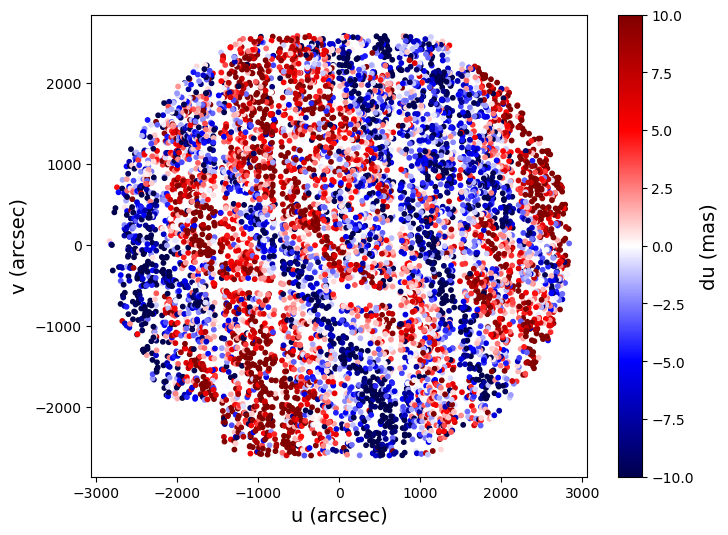

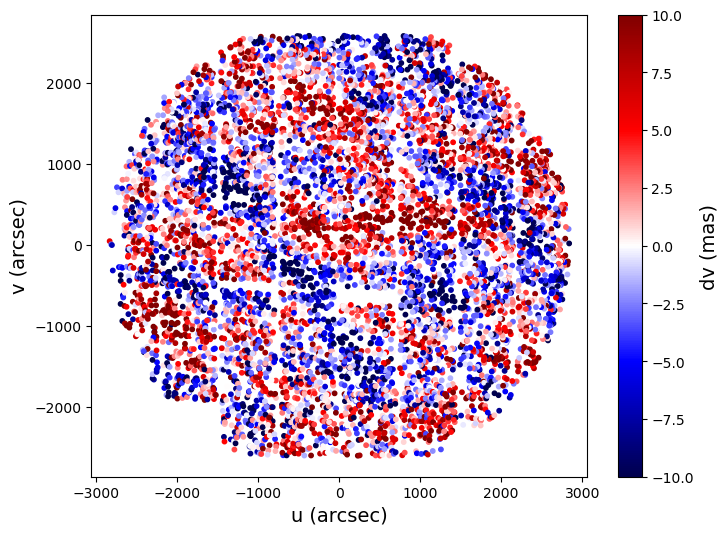

In [5]:
# Plot input data

plt.figure(figsize=(8, 6))
plt.scatter(u, v, c=du, **kwargs_scatter)
scatter_plot_setup(cb_title = 'du (mas)')

plt.figure(figsize=(8, 6))
plt.scatter(u, v, c=dv, **kwargs_scatter)
scatter_plot_setup(cb_title = 'dv (mas)')

time for gp_treegp.__init__ = 0.0014
time for gp_treegp.fit = 10.8073
time for gp_treegp.predict = 7.0733


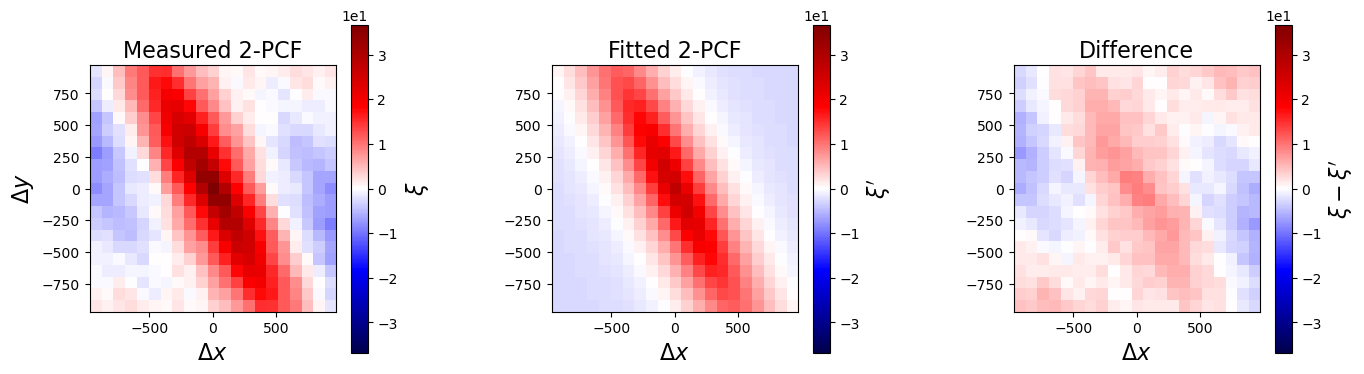

In [6]:
# du fit

gpu = gp_treegp()
gpu.fit(coord[indice_train], du[indice_train], y_err=du_err[indice_train])
du_test = gpu.predict(coord[indice_test])
# plot kernel fit
gpu.gp.plot_fitted_kernel()

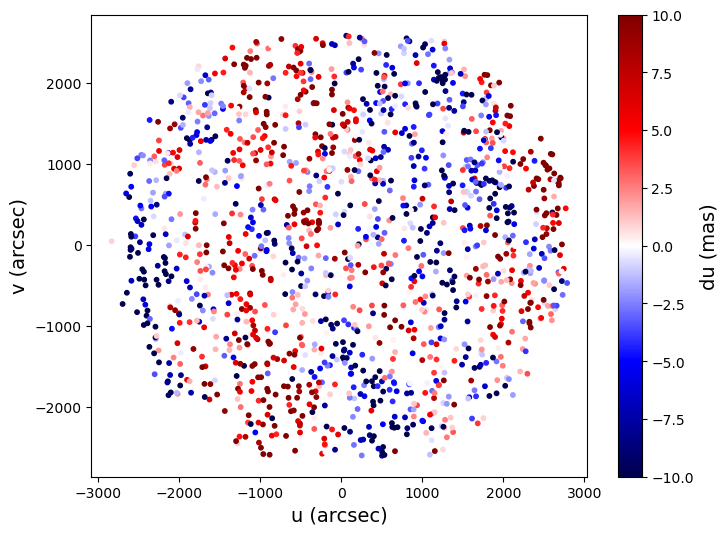

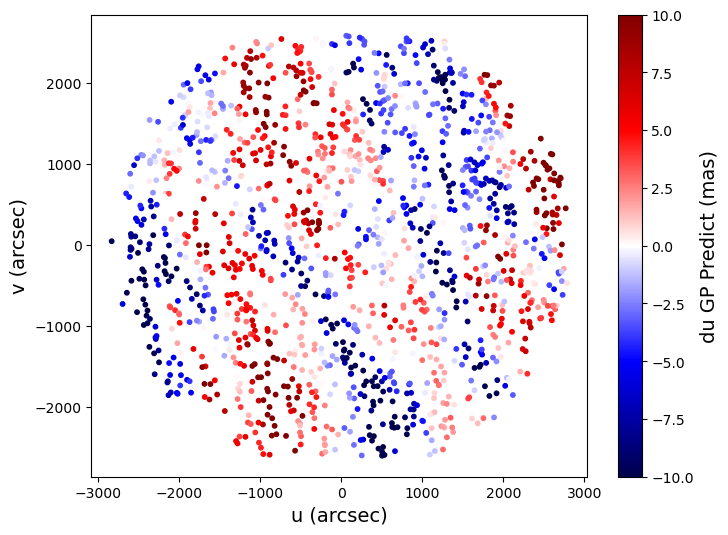

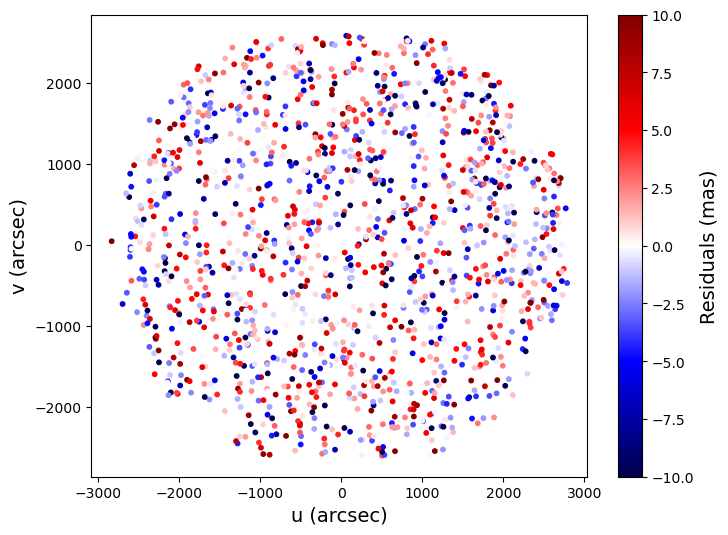

In [7]:
# Plot results for du shift

plt.figure(figsize=(8, 6))
plt.scatter(u[indice_test], v[indice_test], c=du[indice_test], **kwargs_scatter)
scatter_plot_setup(cb_title = 'du (mas)')

plt.figure(figsize=(8, 6))
plt.scatter(u[indice_test], v[indice_test], c=du_test, **kwargs_scatter)
scatter_plot_setup(cb_title = 'du GP Predict (mas)')

plt.figure(figsize=(8, 6))
plt.scatter(u[indice_test], v[indice_test], c=du[indice_test] - du_test, **kwargs_scatter)
scatter_plot_setup(cb_title = 'Residuals (mas)')

time for gp_treegp.__init__ = 0.0009
time for gp_treegp.fit = 16.1323
time for gp_treegp.predict = 7.3910


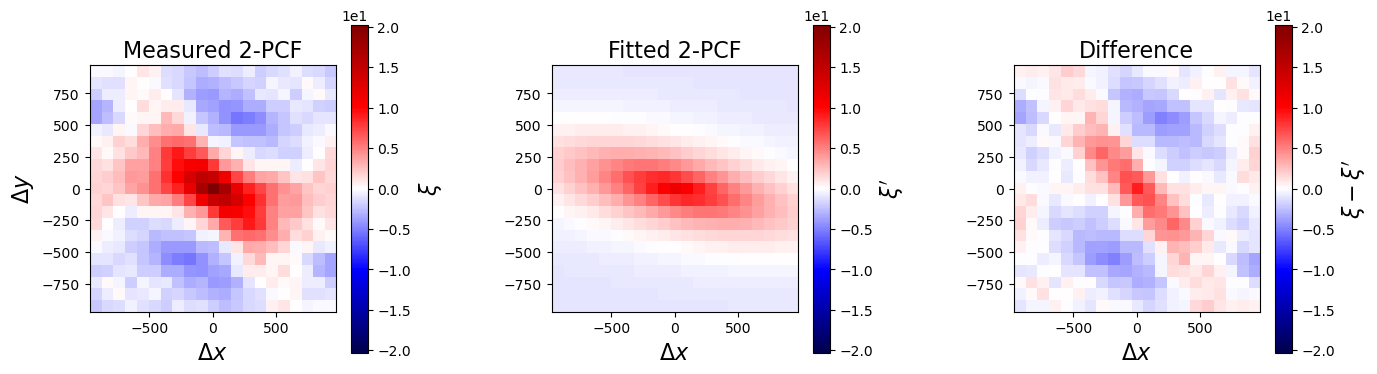

In [8]:
# dv fit

gpv = gp_treegp()
gpv.fit(coord[indice_train], dv[indice_train], y_err=dv_err[indice_train])
dv_test = gpu.predict(coord[indice_test])
# plot kernel fit
gpv.gp.plot_fitted_kernel()

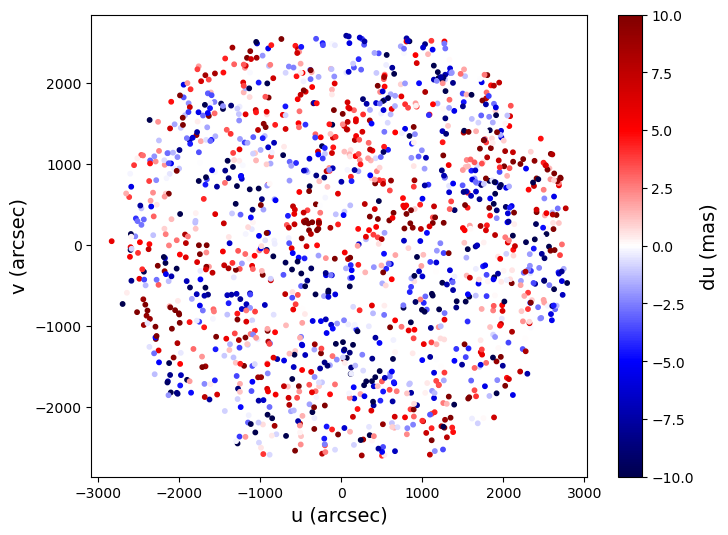

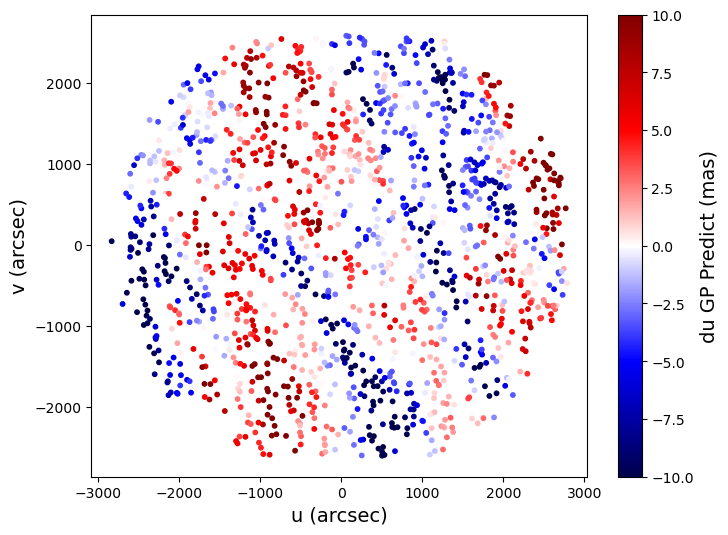

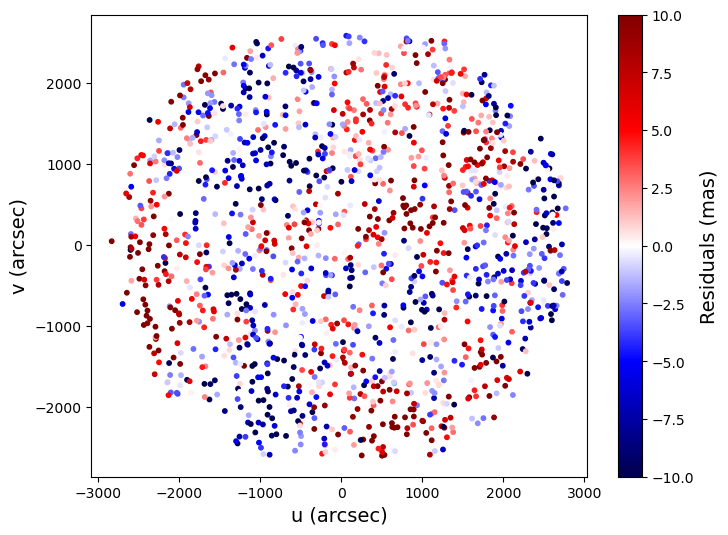

In [9]:
# Plot results for dv shift

plt.figure(figsize=(8, 6))
plt.scatter(u[indice_test], v[indice_test], c=dv[indice_test], **kwargs_scatter)
scatter_plot_setup(cb_title = 'du (mas)')

plt.figure(figsize=(8, 6))
plt.scatter(u[indice_test], v[indice_test], c=dv_test, **kwargs_scatter)
scatter_plot_setup(cb_title = 'du GP Predict (mas)')

plt.figure(figsize=(8, 6))
plt.scatter(u[indice_test], v[indice_test], c=dv[indice_test] - dv_test, **kwargs_scatter)
scatter_plot_setup(cb_title = 'Residuals (mas)')

Length  1456
Length  1456


/Users/leget/software/treegp/treegp/utils.py:46: RuntimeWarning: invalid value encountered in divide
  logr = np.histogram(logdr, bins=bins, range=hrange, weights=logdr)[0] / counts
/Users/leget/software/treegp/treegp/utils.py:51: RuntimeWarning: invalid value encountered in divide
  xiplus = np.histogram(logdr, bins=bins, range=hrange, weights=vv)[0] / counts
/Users/leget/software/treegp/treegp/utils.py:53: RuntimeWarning: invalid value encountered in divide
  xiz2 = np.histogram(logdr, bins=bins, range=hrange, weights=vv)[0] / counts
/Users/leget/software/treegp/treegp/utils.py:61: RuntimeWarning: invalid value encountered in divide
  ximinus = np.histogram(logdr, bins=bins, range=hrange, weights=vv)[0] / counts


Text(0, 0.5, '$\\xi_{E/B}$ (mas$^2$)')

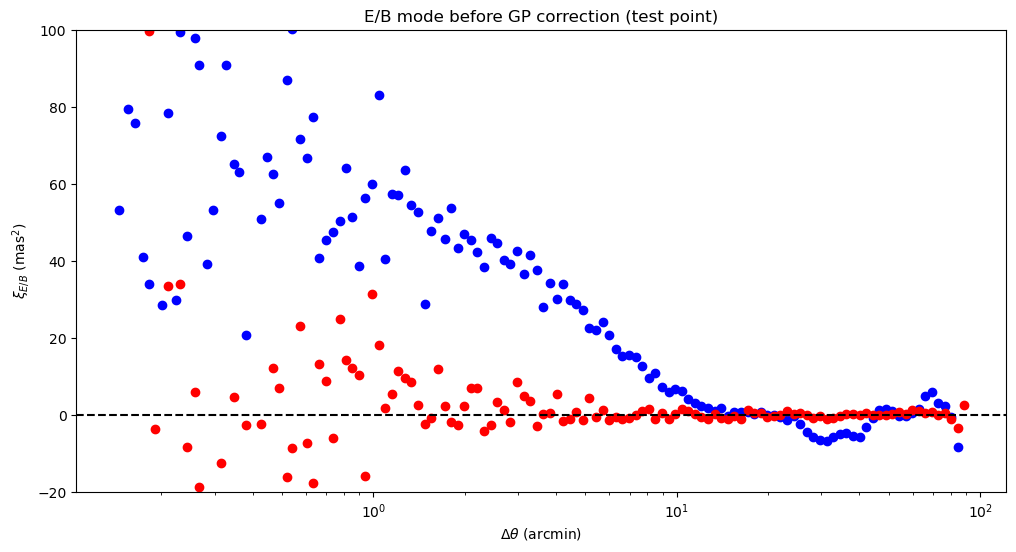

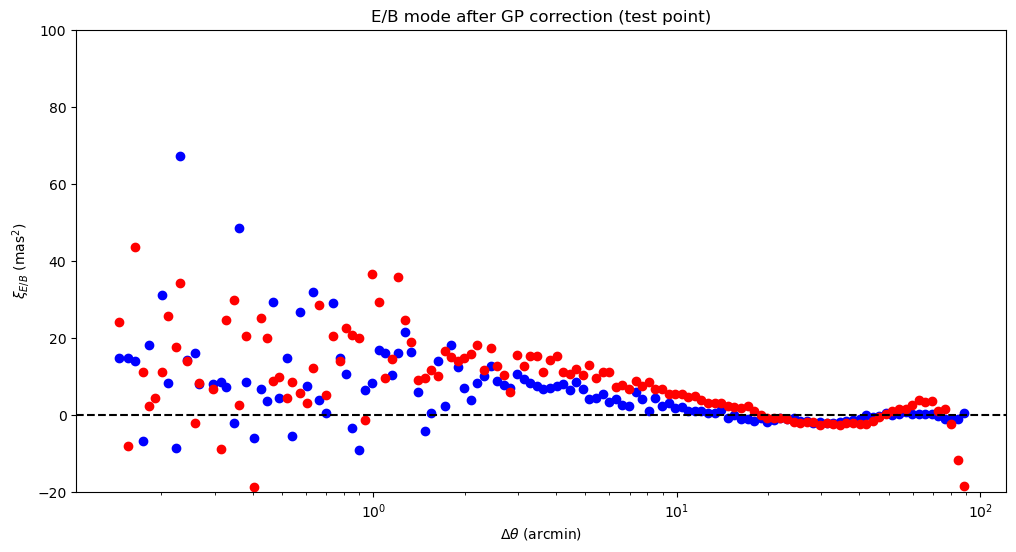

In [10]:
arcsec = 3600.
e_mode, b_mode, logr = treegp.comp_eb(u[indice_test] / arcsec, v[indice_test] / arcsec,
                                      du[indice_test], dv[indice_test])
e_mode_r, b_mode_r, logr = treegp.comp_eb(u[indice_test] / arcsec, v[indice_test] / arcsec, 
                                          du[indice_test] - du_test, dv[indice_test] - dv_test)


plt.figure(figsize=(12,6))
plt.scatter(np.exp(logr) * 60, e_mode, c='b')
plt.scatter(np.exp(logr) * 60, b_mode, c='r')
plt.xscale('log')
xlim = plt.xlim()
plt.plot(xlim, [0,0], 'k--')
plt.xlim(xlim)
plt.ylim(-20, 100)
plt.title('E/B mode before GP correction (test point)')
plt.xlabel(r'$\Delta \theta$ (arcmin)')
plt.ylabel(r'$\xi_{E/B}$ (mas$^2$)')


plt.figure(figsize=(12,6))
plt.scatter(np.exp(logr) * 60, e_mode_r, c='b')
plt.scatter(np.exp(logr) * 60, b_mode_r, c='r')
plt.xscale('log')
xlim = plt.xlim()
plt.plot(xlim, [0,0], 'k--')
plt.xlim(xlim)
plt.ylim(-20, 100)
plt.title('E/B mode after GP correction (test point)')
plt.xlabel(r'$\Delta \theta$ (arcmin)')
plt.ylabel(r'$\xi_{E/B}$ (mas$^2$)')